<a href="https://colab.research.google.com/github/Simi24/AOC_2024/blob/main/particle_filter_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!nvidia-smi

Mon Oct  6 21:10:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [44]:
%%writefile particle_filter_config.h

// particle_filter_config.h
// Configuration and data structures for the particle filter

#ifndef PARTICLE_FILTER_CONFIG_H
#define PARTICLE_FILTER_CONFIG_H

#include <cuda_runtime.h>
#include <curand_kernel.h>

/* =================================================== */
/* SIMULATION PARAMETERS                               */
/* =================================================== */
#define N_PARTICLES      100000000
#define N_TIMESTEPS      100
#define DT               0.1f
#define PROCESS_NOISE    0.3f
#define MEASUREMENT_NOISE 1.0f
#define INIT_NOISE       0.5f

/* =================================================== */
/* CONSTANT MEMORY DECLARATIONS                        */
/* =================================================== */
__constant__ float c_dt = DT;
__constant__ float c_process_noise = PROCESS_NOISE;
__constant__ float c_measurement_noise = MEASUREMENT_NOISE;
__constant__ int c_n_particles = N_PARTICLES;

/* =================================================== */
/* TEXTURE MEMORY DECLARATIONS                         */
/* =================================================== */
// Texture objects are now managed per-particle-filter instance

/* =================================================== */
/* CUDA OPTIMIZATION PARAMETERS                        */
/* =================================================== */
// Optimal thread count for modern GPUs (multiple of 32 for warp alignment)
#define THREADS_PER_BLOCK 256
#define WARP_SIZE        32

// Number of warps per block
#define WARPS_PER_BLOCK  (THREADS_PER_BLOCK / WARP_SIZE)

// For reduction kernels - must be power of 2
#define REDUCTION_THREADS 256

// Number of CUDA streams for concurrent execution
#define NUM_STREAMS      4

// Macro to compute grid size
#define GRID_SIZE(n, block_size) (((n) + (block_size) - 1) / (block_size))

/* =================================================== */
/* ERROR CHECKING MACRO                                */
/* =================================================== */
#define CUDA_CHECK(call) { \
    const cudaError_t error = call; \
    if (error != cudaSuccess) { \
        fprintf(stderr, "CUDA Error: %s:%d, ", __FILE__, __LINE__); \
        fprintf(stderr, "code: %d, reason: %s\n", error, \
                cudaGetErrorString(error)); \
        exit(EXIT_FAILURE); \
    } \
}

/* =================================================== */
/* DATA STRUCTURES                                     */
/* =================================================== */

// Particle structure - aligned for coalesced memory access
typedef struct __align__(16) {
    float x;   // Position x
    float y;   // Position y
    float vx;  // Velocity x
    float vy;  // Velocity y
} Particle;

// Structure for tracking results
typedef struct {
    float time;
    float true_x, true_y;
    float obs_x, obs_y;
    float est_x, est_y;
    float error;
} Result;

/* =================================================== */
/* INLINE DEVICE FUNCTIONS                             */
/* =================================================== */

// Fast square function
__device__ __forceinline__ float square(float x) {
    return x * x;
}

// Warp-level reduction using shuffle instructions (no shared memory)
__device__ __forceinline__ float warp_reduce_sum(float val) {
    #pragma unroll
    for (int offset = WARP_SIZE / 2; offset > 0; offset >>= 1) {
        val += __shfl_down_sync(0xffffffff, val, offset);
    }
    return val;
}

#endif // PARTICLE_FILTER_CONFIG_H

Overwriting particle_filter_config.h


In [45]:
%%writefile scan_kernels.cu
// scan_kernels.cu
// Optimized implementation of parallel prefix sum (scan) to replace Thrust
// Uses Blelloch scan algorithm with work-efficient approach

#include <stdio.h>
#include <stdlib.h>
#include "particle_filter_config.h"

/* =================================================== */
/* INCLUSIVE SCAN (PREFIX SUM) IMPLEMENTATION          */
/* =================================================== */

/**
 * Simple inclusive scan using shared memory - more reliable implementation
 * Based on the classic reduction pattern
 */
__device__ void block_inclusive_scan_simple(float* sdata, int tid, int n) {
    // First, copy to shared memory if needed (assume already done)
    __syncthreads();

    // Perform inclusive scan
    for (int stride = 1; stride < n; stride *= 2) {
        __syncthreads();
        if (tid >= stride && tid < n) {
            sdata[tid] += sdata[tid - stride];
        }
    }
    __syncthreads();
}

/**
 * Kernel 1: Performs scan on blocks and outputs block sums
 * Each block processes THREADS_PER_BLOCK * 2 elements
 */
__global__ void scan_blocks_kernel(
    const float* __restrict__ input,
    float* __restrict__ output,
    float* __restrict__ block_sums,
    int n
) {
    __shared__ float temp[THREADS_PER_BLOCK * 2];

    int tid = threadIdx.x;
    int block_offset = blockIdx.x * THREADS_PER_BLOCK * 2;

    // Load data into shared memory with bounds checking
    int idx1 = block_offset + tid;
    int idx2 = block_offset + tid + THREADS_PER_BLOCK;

    temp[tid] = (idx1 < n) ? input[idx1] : 0.0f;
    temp[tid + THREADS_PER_BLOCK] = (idx2 < n) ? input[idx2] : 0.0f;

    __syncthreads();

    // Determine actual number of elements to scan in this block
    int elements_in_block = min(THREADS_PER_BLOCK * 2, n - block_offset);
    if (elements_in_block <= 0) return;

    // Perform block-level inclusive scan
    block_inclusive_scan_simple(temp, tid, elements_in_block);

    // Write results back to global memory with bounds checking
    if (idx1 < n) output[idx1] = temp[tid];
    if (idx2 < n) output[idx2] = temp[tid + THREADS_PER_BLOCK];

    // Last thread in block writes the block sum
    if (tid == 0 && block_sums != NULL) {
        int last_idx = min(THREADS_PER_BLOCK * 2 - 1, elements_in_block - 1);
        if (last_idx >= 0) {
            block_sums[blockIdx.x] = temp[last_idx];
        }
    }
}

/**
 * Kernel 2: Adds scanned block sums to each block's elements
 * Avoids warp divergence by having all threads in a block work together
 */
__global__ void add_block_sums_kernel(
    float* __restrict__ data,
    const float* __restrict__ block_sums,
    int n
) {
    int tid = threadIdx.x;
    int block_offset = blockIdx.x * THREADS_PER_BLOCK * 2;

    // Check if this block has any valid elements
    if (block_offset >= n) return;

    // Load the cumulative sum from previous blocks
    float block_sum = (blockIdx.x > 0) ? block_sums[blockIdx.x - 1] : 0.0f;

    // Add to both elements this thread is responsible for
    int idx1 = block_offset + tid;
    int idx2 = block_offset + tid + THREADS_PER_BLOCK;

    if (idx1 < n) data[idx1] += block_sum;
    if (idx2 < n) data[idx2] += block_sum;
}

/**
 * Host function: Performs inclusive scan on device array
 * Replaces thrust::inclusive_scan
 *
 * @param d_input: Device input array
 * @param d_output: Device output array
 * @param n: Number of elements
 * @param stream: CUDA stream for async execution
 */
void inclusive_scan(
    const float* d_input,
    float* d_output,
    int n,
    cudaStream_t stream = 0
) {
    if (n <= 0) return;

    // Calculate grid dimensions
    int elements_per_block = THREADS_PER_BLOCK * 2;
    int num_blocks = GRID_SIZE(n, elements_per_block);

    if (num_blocks == 1) {
        // Single block - no need for second pass
        scan_blocks_kernel<<<1, THREADS_PER_BLOCK, 0, stream>>>(
            d_input, d_output, NULL, n
        );
        CUDA_CHECK(cudaStreamSynchronize(stream));
        return;
    }

    // Allocate temporary storage for block sums
    float* d_block_sums;
    CUDA_CHECK(cudaMalloc(&d_block_sums, num_blocks * sizeof(float)));

    // Phase 1: Scan each block
    scan_blocks_kernel<<<num_blocks, THREADS_PER_BLOCK, 0, stream>>>(
        d_input, d_output, d_block_sums, n
    );
    CUDA_CHECK(cudaStreamSynchronize(stream));

    // Phase 2: Scan the block sums recursively if needed
    if (num_blocks > 1) {
        float* d_scanned_block_sums;
        CUDA_CHECK(cudaMalloc(&d_scanned_block_sums, num_blocks * sizeof(float)));

        // Recursively scan block sums
        inclusive_scan(d_block_sums, d_scanned_block_sums, num_blocks, stream);

        // Phase 3: Add scanned block sums to all blocks
        add_block_sums_kernel<<<num_blocks, THREADS_PER_BLOCK, 0, stream>>>(
            d_output, d_scanned_block_sums, n
        );
        CUDA_CHECK(cudaStreamSynchronize(stream));

        CUDA_CHECK(cudaFree(d_scanned_block_sums));
    }

    CUDA_CHECK(cudaFree(d_block_sums));
}

/**
 * In-place version of inclusive scan
 */
void inclusive_scan_inplace(float* d_data, int n, cudaStream_t stream = 0) {
    inclusive_scan(d_data, d_data, n, stream);
}

Overwriting scan_kernels.cu


In [46]:
%%writefile reduce_kernels.cu
// reduce_kernels.cu
// Optimized reduction kernels to replace Thrust reduce operations
// Uses warp shuffle, shared memory, and unwrapping for maximum performance

#include <stdio.h>
#include <stdlib.h>
#include "particle_filter_config.h"

/* =================================================== */
/* REDUCTION KERNELS                                   */
/* =================================================== */

/**
 * Optimized reduction kernel using:
 * - Warp shuffle instructions for final warp reduction (no shared mem needed)
 * - Sequential addressing to avoid bank conflicts
 * - Loop unrolling for better instruction-level parallelism
 * - Each thread processes multiple elements to reduce kernel launches
 *
 * Template allows for different operations (sum, max, etc.)
 */
template<typename T, typename Op>
__global__ void reduce_kernel(
    const T* __restrict__ input,
    T* __restrict__ output,
    int n,
    T identity
) {
    extern __shared__ T sdata[];

    unsigned int tid = threadIdx.x;
    unsigned int i = blockIdx.x * (blockDim.x * 2) + threadIdx.x;
    unsigned int grid_size = blockDim.x * 2 * gridDim.x;

    T sum = identity;

    // Grid-stride loop: each thread accumulates multiple elements
    // This reduces the number of blocks needed
    while (i < n) {
        sum = Op()(sum, input[i]);
        if (i + blockDim.x < n) {
            sum = Op()(sum, input[i + blockDim.x]);
        }
        i += grid_size;
    }

    sdata[tid] = sum;
    __syncthreads();

    // Reduction in shared memory with sequential addressing
    // Unrolled for blocks of 256 threads
    if (blockDim.x >= 512) {
        if (tid < 256) { sdata[tid] = Op()(sdata[tid], sdata[tid + 256]); }
        __syncthreads();
    }
    if (blockDim.x >= 256) {
        if (tid < 128) { sdata[tid] = Op()(sdata[tid], sdata[tid + 128]); }
        __syncthreads();
    }
    if (blockDim.x >= 128) {
        if (tid < 64) { sdata[tid] = Op()(sdata[tid], sdata[tid + 64]); }
        __syncthreads();
    }

    // Final warp reduction using shuffle instructions (no __syncthreads needed)
    if (tid < 32) {
        volatile T* smem = sdata;
        if (blockDim.x >= 64) smem[tid] = Op()(smem[tid], smem[tid + 32]);

        // Last warp uses shuffle instructions - much faster than shared memory
        T val = smem[tid];
        #pragma unroll
        for (int offset = 16; offset > 0; offset >>= 1) {
            T other = __shfl_down_sync(0xffffffff, val, offset);
            val = Op()(val, other);
        }

        if (tid == 0) output[blockIdx.x] = val;
    }
}

/* =================================================== */
/* OPERATION FUNCTORS                                  */
/* =================================================== */

// Functor for sum operation
struct SumOp {
    __device__ __forceinline__ float operator()(float a, float b) const {
        return a + b;
    }
};

// Functor for sum of squares operation (for ESS calculation)
struct SumSquaresOp {
    __device__ __forceinline__ float operator()(float a, float b) const {
        return a + b * b;
    }
};

/* =================================================== */
/* HOST INTERFACE FUNCTIONS                            */
/* =================================================== */

/**
 * Performs sum reduction on device array
 * Replaces thrust::reduce
 *
 * @param d_input: Device input array
 * @param n: Number of elements
 * @param stream: CUDA stream for async execution
 * @return: Sum of all elements
 */
float reduce_sum(const float* d_input, int n, cudaStream_t stream = 0) {
    // Calculate optimal grid size
    // Use fewer blocks but more work per thread for better efficiency
    int threads = REDUCTION_THREADS;
    int blocks = min(256, GRID_SIZE(n, threads * 2));

    // Allocate temporary storage for block results
    float* d_block_results;
    CUDA_CHECK(cudaMalloc(&d_block_results, blocks * sizeof(float)));

    // First reduction
    reduce_kernel<float, SumOp><<<blocks, threads, threads * sizeof(float), stream>>>(
        d_input, d_block_results, n, 0.0f
    );

    float result;
    if (blocks == 1) {
        // Single block - copy result directly
        CUDA_CHECK(cudaMemcpyAsync(&result, d_block_results, sizeof(float),
                                   cudaMemcpyDeviceToHost, stream));
        CUDA_CHECK(cudaStreamSynchronize(stream));
    } else {
        // Multiple blocks - need second reduction
        float* d_final_result;
        CUDA_CHECK(cudaMalloc(&d_final_result, sizeof(float)));

        reduce_kernel<float, SumOp><<<1, threads, threads * sizeof(float), stream>>>(
            d_block_results, d_final_result, blocks, 0.0f
        );

        CUDA_CHECK(cudaMemcpyAsync(&result, d_final_result, sizeof(float),
                                   cudaMemcpyDeviceToHost, stream));
        CUDA_CHECK(cudaStreamSynchronize(stream));
        CUDA_CHECK(cudaFree(d_final_result));
    }

    CUDA_CHECK(cudaFree(d_block_results));
    return result;
}

/**
 * Performs sum of squares reduction
 * Used for ESS (Effective Sample Size) calculation
 * Replaces thrust::transform_reduce with square operation
 *
 * @param d_input: Device input array
 * @param n: Number of elements
 * @param stream: CUDA stream for async execution
 * @return: Sum of squares of all elements
 */
float reduce_sum_squares(const float* d_input, int n, cudaStream_t stream = 0) {
    int threads = REDUCTION_THREADS;
    int blocks = min(256, GRID_SIZE(n, threads * 2));

    float* d_block_results;
    CUDA_CHECK(cudaMalloc(&d_block_results, blocks * sizeof(float)));

    reduce_kernel<float, SumSquaresOp><<<blocks, threads, threads * sizeof(float), stream>>>(
        d_input, d_block_results, n, 0.0f
    );

    float result;
    if (blocks == 1) {
        CUDA_CHECK(cudaMemcpyAsync(&result, d_block_results, sizeof(float),
                                   cudaMemcpyDeviceToHost, stream));
        CUDA_CHECK(cudaStreamSynchronize(stream));
    } else {
        float* d_final_result;
        CUDA_CHECK(cudaMalloc(&d_final_result, sizeof(float)));

        reduce_kernel<float, SumOp><<<1, threads, threads * sizeof(float), stream>>>(
            d_block_results, d_final_result, blocks, 0.0f
        );

        CUDA_CHECK(cudaMemcpyAsync(&result, d_final_result, sizeof(float),
                                   cudaMemcpyDeviceToHost, stream));
        CUDA_CHECK(cudaStreamSynchronize(stream));
        CUDA_CHECK(cudaFree(d_final_result));
    }

    CUDA_CHECK(cudaFree(d_block_results));
    return result;
}

/* =================================================== */
/* WEIGHTED REDUCTION FOR STATE ESTIMATION             */
/* =================================================== */

/**
 * Optimized kernel for computing weighted average in a single pass
 * Reduces memory bandwidth requirements
 */
__global__ void weighted_reduce_kernel(
    const Particle* __restrict__ particles,
    const float* __restrict__ weights,
    int n,
    float* __restrict__ out_x,
    float* __restrict__ out_y
) {
    __shared__ float sdata_x[REDUCTION_THREADS];
    __shared__ float sdata_y[REDUCTION_THREADS];

    unsigned int tid = threadIdx.x;
    unsigned int i = blockIdx.x * (blockDim.x * 2) + threadIdx.x;
    unsigned int grid_size = blockDim.x * 2 * gridDim.x;

    float sum_x = 0.0f;
    float sum_y = 0.0f;

    // Grid-stride loop for coalesced memory access
    while (i < n) {
        float w = weights[i];
        sum_x += particles[i].x * w;
        sum_y += particles[i].y * w;

        if (i + blockDim.x < n) {
            float w2 = weights[i + blockDim.x];
            sum_x += particles[i + blockDim.x].x * w2;
            sum_y += particles[i + blockDim.x].y * w2;
        }
        i += grid_size;
    }

    sdata_x[tid] = sum_x;
    sdata_y[tid] = sum_y;
    __syncthreads();

    // Reduction with unrolling
    if (blockDim.x >= 512) {
        if (tid < 256) {
            sdata_x[tid] += sdata_x[tid + 256];
            sdata_y[tid] += sdata_y[tid + 256];
        }
        __syncthreads();
    }
    if (blockDim.x >= 256) {
        if (tid < 128) {
            sdata_x[tid] += sdata_x[tid + 128];
            sdata_y[tid] += sdata_y[tid + 128];
        }
        __syncthreads();
    }
    if (blockDim.x >= 128) {
        if (tid < 64) {
            sdata_x[tid] += sdata_x[tid + 64];
            sdata_y[tid] += sdata_y[tid + 64];
        }
        __syncthreads();
    }

    // Final warp reduction
    if (tid < 32) {
        volatile float* smem_x = sdata_x;
        volatile float* smem_y = sdata_y;
        if (blockDim.x >= 64) {
            smem_x[tid] += smem_x[tid + 32];
            smem_y[tid] += smem_y[tid + 32];
        }

        float val_x = smem_x[tid];
        float val_y = smem_y[tid];
        #pragma unroll
        for (int offset = 16; offset > 0; offset >>= 1) {
            val_x += __shfl_down_sync(0xffffffff, val_x, offset);
            val_y += __shfl_down_sync(0xffffffff, val_y, offset);
        }

        if (tid == 0) {
            out_x[blockIdx.x] = val_x;
            out_y[blockIdx.x] = val_y;
        }
    }
}

/**
 * Computes weighted average of particle positions
 * Returns result through output parameters
 */
void weighted_average(
    const Particle* d_particles,
    const float* d_weights,
    int n,
    float* est_x,
    float* est_y,
    cudaStream_t stream = 0
) {
    int threads = REDUCTION_THREADS;
    int blocks = min(256, GRID_SIZE(n, threads * 2));

    float *d_block_x, *d_block_y;
    CUDA_CHECK(cudaMalloc(&d_block_x, blocks * sizeof(float)));
    CUDA_CHECK(cudaMalloc(&d_block_y, blocks * sizeof(float)));

    weighted_reduce_kernel<<<blocks, threads, 0, stream>>>(
        d_particles, d_weights, n, d_block_x, d_block_y
    );

    if (blocks == 1) {
        CUDA_CHECK(cudaMemcpyAsync(est_x, d_block_x, sizeof(float),
                                   cudaMemcpyDeviceToHost, stream));
        CUDA_CHECK(cudaMemcpyAsync(est_y, d_block_y, sizeof(float),
                                   cudaMemcpyDeviceToHost, stream));
        CUDA_CHECK(cudaStreamSynchronize(stream));
    } else {
        // Perform final reduction on the block results
        float *d_final_x, *d_final_y;
        CUDA_CHECK(cudaMalloc(&d_final_x, sizeof(float)));
        CUDA_CHECK(cudaMalloc(&d_final_y, sizeof(float)));

        // Final reduction for x
        reduce_kernel<float, SumOp><<<1, threads, threads * sizeof(float), stream>>>(
            d_block_x, d_final_x, blocks, 0.0f
        );

        // Final reduction for y
        reduce_kernel<float, SumOp><<<1, threads, threads * sizeof(float), stream>>>(
            d_block_y, d_final_y, blocks, 0.0f
        );

        // Copy results back to host
        CUDA_CHECK(cudaMemcpyAsync(est_x, d_final_x, sizeof(float),
                                   cudaMemcpyDeviceToHost, stream));
        CUDA_CHECK(cudaMemcpyAsync(est_y, d_final_y, sizeof(float),
                                   cudaMemcpyDeviceToHost, stream));
        CUDA_CHECK(cudaStreamSynchronize(stream));

        CUDA_CHECK(cudaFree(d_final_x));
        CUDA_CHECK(cudaFree(d_final_y));
    }

    CUDA_CHECK(cudaFree(d_block_x));
    CUDA_CHECK(cudaFree(d_block_y));
}

Overwriting reduce_kernels.cu


In [47]:
%%writefile particle_filter_kernels.cu
// particle_filter_kernels.cu
// Core particle filter CUDA kernels with full optimizations

#include <stdio.h>
#include <stdlib.h>
#include "particle_filter_config.h"

/* =================================================== */
/* TRAJECTORY GENERATION                               */
/* =================================================== */

/**
 * Generates true trajectory (ground truth)
 * Piecewise motion model for realistic tracking scenario
 */
__host__ __device__ void generate_trajectory(
    float t,
    float* x,
    float* y
) {
    const float speed = 3.0f;

    if (t < 2.0f) {
        // Straight line motion
        *x = 0.0f + speed * t;
        *y = 0.0f;
    } else if (t < 4.0f) {
        // Accelerating turn
        float t_local = t - 2.0f;
        *x = 6.0f + speed * t_local;
        *y = 0.5f * t_local * t_local;
    } else if (t < 6.0f) {
        // Diagonal motion
        float t_local = t - 4.0f;
        *x = 12.0f + speed * 0.7f * t_local;
        *y = 2.0f + speed * 0.7f * t_local;
    } else if (t < 8.0f) {
        // Descending turn
        float t_local = t - 6.0f;
        *x = 16.2f + speed * 0.5f * t_local;
        *y = 10.8f - speed * 0.8f * t_local;
    } else {
        // Final straight segment
        float t_local = t - 8.0f;
        *x = 19.2f + speed * t_local;
        *y = 4.4f + speed * 0.2f * t_local;
    }
}

extern "C" {

/* =================================================== */
/* PARTICLE INITIALIZATION                             */
/* =================================================== */

/**
 * Initializes particles with random perturbations around initial state
 * Optimized for:
 * - Coalesced memory access (threads access consecutive particles)
 * - Efficient random number generation (cuRAND)
 *
 * @param particles: Output particle array
 * @param rand_states: cuRAND state for each particle
 * @param n: Number of particles
 * @param init_x, init_y: Initial position
 */
__global__ void init_particles_kernel(
    Particle* __restrict__ particles,
    curandState* __restrict__ rand_states,
    int n,
    float init_x,
    float init_y
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    // Guard against out-of-bounds access
    if (idx >= n) return;

    // Initialize random state for this particle first
    curand_init(1234ULL + idx, 0, 0, &rand_states[idx]);

    // Initialize particle with small random noise around initial position
    float noise_x = curand_normal(&rand_states[idx]) * INIT_NOISE;
    float noise_y = curand_normal(&rand_states[idx]) * INIT_NOISE;
    float noise_vx = curand_normal(&rand_states[idx]) * 0.1f;  // Small velocity noise
    float noise_vy = curand_normal(&rand_states[idx]) * 0.1f;

    particles[idx].x = init_x + noise_x;
    particles[idx].y = init_y + noise_y;
    particles[idx].vx = 3.0f + noise_vx;  // Initial velocity around 3.0
    particles[idx].vy = 0.0f + noise_vy;  // Initial vy around 0.0
}

/* =================================================== */
/* PREDICTION STEP                                     */
/* =================================================== */

/**
 * Predicts particle states forward in time using motion model
 * Optimized for:
 * - Coalesced memory access
 * - Minimal register usage
 * - No warp divergence (all threads execute same path)
 *
 * @param particles: Input/output particle array
 * @param rand_states: Random number generator states
 * @param n: Number of particles
 * @param dt: Time step
 * @param process_noise: Process noise standard deviation
 */
__global__ void predict_kernel(
    Particle* __restrict__ particles,
    curandState* __restrict__ rand_states,
    int n
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= n) return;

    // Load random state to local memory for efficiency
    curandState local_state = rand_states[idx];

    // Load particle to registers
    Particle p = particles[idx];

    // Constant velocity model with Gaussian noise (using constant memory)
    float noise_scale = c_process_noise * c_dt;
    p.x += p.vx * c_dt + curand_normal(&local_state) * noise_scale;
    p.y += p.vy * c_dt + curand_normal(&local_state) * noise_scale;

    // Velocity random walk
    float vel_noise_scale = c_process_noise * 0.2f * c_dt;
    p.vx += curand_normal(&local_state) * vel_noise_scale;
    p.vy += curand_normal(&local_state) * vel_noise_scale;

    // Write back to global memory
    particles[idx] = p;
    rand_states[idx] = local_state;
}

/* =================================================== */
/* UPDATE WEIGHTS (MEASUREMENT UPDATE)                 */
/* =================================================== */

/**
 * Updates particle weights based on observation likelihood
 * Optimized for:
 * - Coalesced reads/writes
 * - Fast math operations (no divergence)
 * - Minimal memory transactions
 *
 * @param particles: Input particle array
 * @param weights: Output weights array
 * @param n: Number of particles
 * @param obs_x, obs_y: Observed position
 * @param measurement_noise: Measurement noise standard deviation
 */
__global__ void update_weights_kernel(
    const Particle* __restrict__ particles,
    float* __restrict__ weights,
    int n,
    float obs_x,
    float obs_y
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= n) return;

    // Load particle position to registers
    float px = particles[idx].x;
    float py = particles[idx].y;

    // Compute squared distance to observation
    float dx = px - obs_x;
    float dy = py - obs_y;
    float dist_sq = dx * dx + dy * dy;

    // Gaussian likelihood with small epsilon to avoid zero weights (using constant memory)
    float variance = c_measurement_noise * c_measurement_noise;
    float likelihood = __expf(-dist_sq / (2.0f * variance)) + 1e-10f;

    // Store weight
    weights[idx] = likelihood;
}

/* =================================================== */
/* WEIGHT NORMALIZATION                                */
/* =================================================== */

/**
 * Normalizes weights and cumulative weights
 * Optimized for coalesced memory access
 *
 * @param weights: Input/output normalized weights
 * @param cumulative_weights: Input/output normalized cumulative weights
 * @param n: Number of particles
 * @param total_weight: Sum of all weights
 */
__global__ void normalize_weights_kernel(
    float* __restrict__ weights,
    float* __restrict__ cumulative_weights,
    int n,
    float total_weight
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= n) return;

    // Avoid division by zero
    float norm_factor = (total_weight > 1e-10f) ? (1.0f / total_weight) : (1.0f / n);

    // Normalize both arrays in a single kernel launch
    weights[idx] *= norm_factor;
    cumulative_weights[idx] *= norm_factor;
}

/* =================================================== */
/* SYSTEMATIC RESAMPLING                               */
/* =================================================== */

/**
 * Performs systematic resampling using binary search
 * Optimized version with:
 * - Coalesced memory access for input particles
 * - Efficient binary search (avoids linear search divergence)
 * - Strided writes to avoid bank conflicts
 *
 * @param particles_in: Input particles (to be resampled)
 * @param particles_out: Output resampled particles
 * @param cumulative_weights: Normalized cumulative weights
 * @param n: Number of particles
 * @param random_offset: Random offset for systematic resampling
 */
__global__ void resample_kernel(
    const Particle* __restrict__ particles_in,
    Particle* __restrict__ particles_out,
    const float* __restrict__ cumulative_weights,
    int n,
    float random_offset
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= n) return;

    // Compute systematic sample position
    float position = random_offset + (float)idx / n;

    // Binary search for the particle to resample
    // This is much more efficient than linear search for large N
    int left = 0;
    int right = n - 1;
    int selected_idx = 0;

    // Unrolled binary search for better performance
    #pragma unroll 8
    while (left <= right) {
        int mid = (left + right) >> 1;
        float cum_weight = cumulative_weights[mid];

        if (cum_weight < position) {
            left = mid + 1;
        } else {
            selected_idx = mid;
            right = mid - 1;
        }
    }

    // Copy selected particle to output (coalesced write)
    particles_out[idx] = particles_in[selected_idx];
}

/* =================================================== */
/* OPTIMIZED RESAMPLING WITH SHARED MEMORY             */
/* =================================================== */

/**
 * Advanced resampling kernel using shared memory caching
 * Further optimized for large particle counts
 *
 * Loads cumulative weights into shared memory in blocks
 * to reduce global memory accesses during binary search
 */
__global__ void resample_optimized_kernel(
    const Particle* __restrict__ particles_in,
    Particle* __restrict__ particles_out,
    cudaTextureObject_t tex_weights_obj,
    int n,
    float random_offset
) {
    __shared__ float s_cum_weights[THREADS_PER_BLOCK + 1];

    int tid = threadIdx.x;
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= n) return;

    // Compute systematic sample position
    float position = random_offset + (float)idx / n;

    // Collaborative loading of cumulative weights to shared memory
    // Each block loads a window of cumulative weights
    int block_start = blockIdx.x * blockDim.x;
    if (tid < blockDim.x && block_start + tid < n) {
        s_cum_weights[tid] = tex1Dfetch<float>(tex_weights_obj, block_start + tid);
    }
    if (tid == 0 && block_start + blockDim.x < n) {
        s_cum_weights[blockDim.x] = tex1Dfetch<float>(tex_weights_obj, block_start + blockDim.x);
    }
    __syncthreads();

    // Fast path: check if position is in current block's range
    int selected_idx;
    if (block_start > 0 && position < tex1Dfetch<float>(tex_weights_obj, block_start - 1)) {
        // Need to search in previous blocks - use binary search on global memory
        int left = 0;
        int right = block_start - 1;
        selected_idx = 0;

        while (left <= right) {
            int mid = (left + right) >> 1;
            if (tex1Dfetch<float>(tex_weights_obj, mid) < position) {
                left = mid + 1;
            } else {
                selected_idx = mid;
                right = mid - 1;
            }
        }
    } else if (block_start + blockDim.x < n &&
               position >= s_cum_weights[blockDim.x - 1]) {
        // Need to search in later blocks
        int left = block_start + blockDim.x;
        int right = n - 1;
        selected_idx = left;

        while (left <= right) {
            int mid = (left + right) >> 1;
            if (tex1Dfetch<float>(tex_weights_obj, mid) < position) {
                left = mid + 1;
            } else {
                selected_idx = mid;
                right = mid - 1;
            }
        }
    } else {
        // Position is in current block - search in shared memory
        int left = 0;
        int right = min(blockDim.x - 1, n - block_start - 1);
        int local_idx = 0;

        while (left <= right) {
            int mid = (left + right) >> 1;
            if (s_cum_weights[mid] < position) {
                left = mid + 1;
            } else {
                local_idx = mid;
                right = mid - 1;
            }
        }
        selected_idx = block_start + local_idx;
    }

    // Copy selected particle (coalesced write)
    particles_out[idx] = particles_in[selected_idx];
}

/* =================================================== */
/* UTILITY KERNELS                                     */
/* =================================================== */

/**
 * Sets all weights to a uniform value
 * Used after resampling to reset particle weights
 */
__global__ void set_uniform_weights_kernel(
    float* __restrict__ weights,
    int n,
    float value
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        weights[idx] = value;
    }
}

} // extern "C"

Overwriting particle_filter_kernels.cu


In [48]:
%%writefile utils.cu
#include "particle_filter_config.h"
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <cuda_runtime.h>

/* =================================================== */
/* HOST RANDOM NUMBER GENERATION                       */
/* =================================================== */

/**
 * Box-Muller transform for generating Gaussian random numbers on host
 * Used for generating noisy observations
 */
float randn_host(float mean, float stddev) {
    static int has_spare = 0;
    static float spare;

    if (has_spare) {
        has_spare = 0;
        return mean + stddev * spare;
    }

    has_spare = 1;
    float u, v, s;

    do {
        u = (rand() / ((float)RAND_MAX)) * 2.0f - 1.0f;
        v = (rand() / ((float)RAND_MAX)) * 2.0f - 1.0f;
        s = u * u + v * v;
    } while (s >= 1.0f || s == 0.0f);

    s = sqrtf(-2.0f * logf(s) / s);
    spare = v * s;
    return mean + stddev * u * s;
}

/* =================================================== */
/* FILE I/O UTILITIES                                  */
/* =================================================== */

/**
 * Opens a file with error checking
 */
FILE* safe_fopen(const char* filename, const char* mode) {
    FILE* file = fopen(filename, mode);
    if (!file) {
        fprintf(stderr, "Error: Could not open file %s\n", filename);
        exit(EXIT_FAILURE);
    }
    return file;
}

/**
 * Writes result to CSV file
 */
void write_result(FILE* file, const Result* result) {
    fprintf(file, "%f,%f,%f,%f,%f,%f,%f,%f\n",
            result->time,
            result->true_x, result->true_y,
            result->obs_x, result->obs_y,
            result->est_x, result->est_y,
            result->error);
}

/**
 * Writes particle data to CSV file (for visualization)
 */
void write_particles(
    FILE* file,
    int timestep,
    const Particle* h_particles,
    const float* h_weights,
    int n_particles
) {
    for (int i = 0; i < n_particles; ++i) {
        fprintf(file, "%d,%f,%f,%f\n",
                timestep,
                h_particles[i].x,
                h_particles[i].y,
                h_weights[i]);
    }
}

/* =================================================== */
/* MEMORY ALLOCATION UTILITIES                         */
/* =================================================== */

/**
 * Allocates pinned (page-locked) host memory for faster transfers
 * Pinned memory allows asynchronous copies and higher bandwidth
 */
void* allocate_pinned_memory(size_t size) {
    void* ptr;
    CUDA_CHECK(cudaMallocHost(&ptr, size));
    return ptr;
}

/**
 * Frees pinned host memory
 */
void free_pinned_memory(void* ptr) {
    CUDA_CHECK(cudaFreeHost(ptr));
}

/* =================================================== */
/* DEVICE INFORMATION                                  */
/* =================================================== */

/**
 * Prints GPU device information
 * Useful for understanding performance characteristics
 */
void print_device_info() {
    int device;
    CUDA_CHECK(cudaGetDevice(&device));

    cudaDeviceProp prop;
    CUDA_CHECK(cudaGetDeviceProperties(&prop, device));

    printf("\n=== GPU Device Information ===\n");
    printf("Device: %s\n", prop.name);
    printf("Compute Capability: %d.%d\n", prop.major, prop.minor);
    printf("Total Global Memory: %.2f GB\n",
           prop.totalGlobalMem / (1024.0 * 1024.0 * 1024.0));
    printf("Multiprocessors: %d\n", prop.multiProcessorCount);
    printf("Max Threads per Block: %d\n", prop.maxThreadsPerBlock);
    printf("Warp Size: %d\n", prop.warpSize);
    printf("Shared Memory per Block: %.2f KB\n",
           prop.sharedMemPerBlock / 1024.0);
    printf("==============================\n\n");
}

/* =================================================== */
/* PERFORMANCE TIMING                                  */
/* =================================================== */

/**
 * Simple timer structure for CPU timing
 */
typedef struct {
    clock_t start;
    clock_t end;
} CPUTimer;

/**
 * GPU timer using CUDA events
 */
typedef struct {
    cudaEvent_t start;
    cudaEvent_t stop;
} GPUTimer;

void cpu_timer_start(CPUTimer* timer) {
    timer->start = clock();
}

float cpu_timer_stop(CPUTimer* timer) {
    timer->end = clock();
    return ((float)(timer->end - timer->start)) / CLOCKS_PER_SEC;
}

void gpu_timer_create(GPUTimer* timer) {
    CUDA_CHECK(cudaEventCreate(&timer->start));
    CUDA_CHECK(cudaEventCreate(&timer->stop));
}

void gpu_timer_start(GPUTimer* timer) {
    CUDA_CHECK(cudaEventRecord(timer->start));
}

float gpu_timer_stop(GPUTimer* timer) {
    CUDA_CHECK(cudaEventRecord(timer->stop));
    CUDA_CHECK(cudaEventSynchronize(timer->stop));

    float milliseconds = 0;
    CUDA_CHECK(cudaEventElapsedTime(&milliseconds, timer->start, timer->stop));
    return milliseconds / 1000.0f; // Convert to seconds
}

void gpu_timer_destroy(GPUTimer* timer) {
    CUDA_CHECK(cudaEventDestroy(timer->start));
    CUDA_CHECK(cudaEventDestroy(timer->stop));
}

/* =================================================== */
/* STATISTICS UTILITIES                                */
/* =================================================== */

/**
 * Computes RMSE from array of errors
 */
float compute_rmse(const float* errors, int n) {
    float sum = 0.0f;
    for (int i = 0; i < n; ++i) {
        sum += errors[i] * errors[i];
    }
    return sqrtf(sum / n);
}

/**
 * Computes mean of array
 */
float compute_mean(const float* values, int n) {
    float sum = 0.0f;
    for (int i = 0; i < n; ++i) {
        sum += values[i];
    }
    return sum / n;
}

/**
 * Computes standard deviation
 */
float compute_stddev(const float* values, int n, float mean) {
    float sum_sq = 0.0f;
    for (int i = 0; i < n; ++i) {
        float diff = values[i] - mean;
        sum_sq += diff * diff;
    }
    return sqrtf(sum_sq / n);
}

Overwriting utils.cu


In [49]:
%%writefile particle_filter_main.cu
// particle_filter_main.cu
// Main program for optimized CUDA particle filter
// Integrates all components with multi-stream execution

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>

#include "particle_filter_config.h"

// GPU Timer structure
typedef struct {
    cudaEvent_t start;
    cudaEvent_t stop;
} GPUTimer;

// Forward declarations for external functions
extern void inclusive_scan(const float*, float*, int, cudaStream_t);
extern float reduce_sum(const float*, int, cudaStream_t);
extern float reduce_sum_squares(const float*, int, cudaStream_t);
extern void weighted_average(const Particle*, const float*, int, float*, float*, cudaStream_t);
extern void debug_simple_average(const Particle*, int, float*, float*, cudaStream_t);

// Forward declarations for kernel launches
extern "C" {
    __global__ void init_particles_kernel(Particle*, curandState*, int, float, float);
    __global__ void predict_kernel(Particle*, curandState*, int);
    __global__ void update_weights_kernel(const Particle*, float*, int, float, float);
    __global__ void normalize_weights_kernel(float*, float*, int, float);
    __global__ void resample_kernel(const Particle*, Particle*, const float*, int, float);
    __global__ void resample_optimized_kernel(const Particle*, Particle*, cudaTextureObject_t, int, float);
    __global__ void set_uniform_weights_kernel(float*, int, float);
}

// Utility functions
extern float randn_host(float, float);
extern FILE* safe_fopen(const char*, const char*);
extern void write_result(FILE*, const Result*);
extern void print_device_info();
extern void gpu_timer_create(GPUTimer*);
extern void gpu_timer_start(GPUTimer*);
extern float gpu_timer_stop(GPUTimer*);
extern void gpu_timer_destroy(GPUTimer*);
extern float compute_rmse(const float*, int);
extern float compute_mean(const float*, int);
extern float compute_stddev(const float*, int, float);

// Trajectory generation (also in kernels file)
extern void generate_trajectory(float, float*, float*);

/* =================================================== */
/* PARTICLE FILTER STATE STRUCTURE                     */
/* =================================================== */

typedef struct {
    // Device memory
    Particle* d_particles[2];      // Double buffer for resampling
    float* d_weights;
    float* d_cumulative_weights;
    curandState* d_rand_states;

    // Texture object for weights
    cudaTextureObject_t tex_weights_obj;

    // Pinned host memory for async transfers
    float* h_est_x_pinned;
    float* h_est_y_pinned;

    // CUDA streams for concurrent execution
    cudaStream_t streams[NUM_STREAMS];

    // Configuration
    int n_particles;
    int current_buffer;

    // Grid configuration
    int threads_per_block;
    int blocks_per_grid;
} ParticleFilterState;

/* =================================================== */
/* INITIALIZATION                                      */
/* =================================================== */

/**
 * Initializes the particle filter state
 * Allocates all GPU and pinned host memory
 * Creates CUDA streams for concurrent execution
 */
void initialize_particle_filter(ParticleFilterState* pf, int n_particles) {
    pf->n_particles = n_particles;
    pf->current_buffer = 0;
    pf->threads_per_block = THREADS_PER_BLOCK;
    pf->blocks_per_grid = GRID_SIZE(n_particles, THREADS_PER_BLOCK);

    printf("Initializing Particle Filter...\n");
    printf("Particles: %d\n", n_particles);
    printf("Blocks: %d, Threads per block: %d\n",
           pf->blocks_per_grid, pf->threads_per_block);

    // Allocate device memory
    size_t particle_size = n_particles * sizeof(Particle);
    size_t float_size = n_particles * sizeof(float);
    size_t state_size = n_particles * sizeof(curandState);

    CUDA_CHECK(cudaMalloc(&pf->d_particles[0], particle_size));
    CUDA_CHECK(cudaMalloc(&pf->d_particles[1], particle_size));
    CUDA_CHECK(cudaMalloc(&pf->d_weights, float_size));
    CUDA_CHECK(cudaMalloc(&pf->d_cumulative_weights, float_size));
    CUDA_CHECK(cudaMalloc(&pf->d_rand_states, state_size));

    // Allocate pinned host memory for faster transfers
    CUDA_CHECK(cudaMallocHost(&pf->h_est_x_pinned, sizeof(float)));
    CUDA_CHECK(cudaMallocHost(&pf->h_est_y_pinned, sizeof(float)));

    // Create CUDA streams
    for (int i = 0; i < NUM_STREAMS; ++i) {
        CUDA_CHECK(cudaStreamCreate(&pf->streams[i]));
    }

    printf("Memory allocated successfully\n");
    printf("Total GPU memory used: %.2f MB\n",
           (2 * particle_size + 2 * float_size + state_size) / (1024.0 * 1024.0));
}

/**
 * Initializes particles around initial position
 */
void initialize_particles(ParticleFilterState* pf, float init_x, float init_y) {
    printf("Launching init_particles_kernel with %d blocks, %d threads\n",
           pf->blocks_per_grid, pf->threads_per_block);

    init_particles_kernel<<<pf->blocks_per_grid, pf->threads_per_block>>>(
        pf->d_particles[0],
        pf->d_rand_states,
        pf->n_particles,
        init_x,
        init_y
    );

    // Check for kernel launch errors
    cudaError_t launch_error = cudaGetLastError();
    if (launch_error != cudaSuccess) {
        printf("ERROR: Kernel launch failed: %s\n", cudaGetErrorString(launch_error));
        exit(EXIT_FAILURE);
    }

    CUDA_CHECK(cudaDeviceSynchronize());

    // Check for kernel execution errors
    cudaError_t exec_error = cudaGetLastError();
    if (exec_error != cudaSuccess) {
        printf("ERROR: Kernel execution failed: %s\n", cudaGetErrorString(exec_error));
        exit(EXIT_FAILURE);
    }

    printf("Particles initialized at (%.2f, %.2f)\n", init_x, init_y);

    // Debug: Check first few particles
    Particle* h_particles = (Particle*)malloc(10 * sizeof(Particle));
    CUDA_CHECK(cudaMemcpy(h_particles, pf->d_particles[0], 10 * sizeof(Particle), cudaMemcpyDeviceToHost));
    printf("DEBUG: First 3 particles after init:\n");
    for (int i = 0; i < 3; i++) {
        printf("  Particle %d: x=%.6f, y=%.6f, vx=%.6f, vy=%.6f\n",
               i, h_particles[i].x, h_particles[i].y, h_particles[i].vx, h_particles[i].vy);
    }
    free(h_particles);
}

/* =================================================== */
/* PARTICLE FILTER STEP                                */
/* =================================================== */

/**
 * Executes one complete particle filter iteration
 * Uses streams for overlapping computation where possible
 *
 * @return: Estimated state (x, y) and error
 */
Result particle_filter_step(
    ParticleFilterState* pf,
    float time,
    float obs_x,
    float obs_y,
    float true_x,
    float true_y
) {
    // Select current particle buffer
    int curr_buf = pf->current_buffer;
    Particle* d_particles_curr = pf->d_particles[curr_buf];
    Particle* d_particles_next = pf->d_particles[1 - curr_buf];

    // Assign streams for different phases
    cudaStream_t predict_stream = pf->streams[0];
    cudaStream_t weight_stream = pf->streams[1];
    cudaStream_t scan_stream = pf->streams[2];
    cudaStream_t resample_stream = pf->streams[3];

    // ============ PREDICTION STEP ============
    predict_kernel<<<pf->blocks_per_grid, pf->threads_per_block, 0, predict_stream>>>(
        d_particles_curr,
        pf->d_rand_states,
        pf->n_particles
    );

    // Wait for prediction to complete before weight update (data dependency)
    CUDA_CHECK(cudaStreamSynchronize(predict_stream));

    // Debug: Check particles after prediction (only for first timestep)
    if (time < 0.01f) {  // Only for t=0
        Particle* h_particles = (Particle*)malloc(3 * sizeof(Particle));
        CUDA_CHECK(cudaMemcpy(h_particles, d_particles_curr, 3 * sizeof(Particle), cudaMemcpyDeviceToHost));
        printf("DEBUG: First 3 particles after prediction at t=%.1f:\n", time);
        for (int i = 0; i < 3; i++) {
            printf("  Particle %d: x=%.6f, y=%.6f, vx=%.6f, vy=%.6f\n",
                   i, h_particles[i].x, h_particles[i].y, h_particles[i].vx, h_particles[i].vy);
        }
        free(h_particles);
    }

    // ============ UPDATE WEIGHTS ============
    update_weights_kernel<<<pf->blocks_per_grid, pf->threads_per_block, 0, weight_stream>>>(
        d_particles_curr,
        pf->d_weights,
        pf->n_particles,
        obs_x,
        obs_y
    );

    // ============ COMPUTE CUMULATIVE WEIGHTS ============
    // Wait for weight update to complete before scan
    CUDA_CHECK(cudaStreamSynchronize(weight_stream));

    // Perform inclusive scan (prefix sum) on weights
    inclusive_scan(
        pf->d_weights,
        pf->d_cumulative_weights,
        pf->n_particles,
        scan_stream
    );

    // Get total weight (last element of cumulative sum)
    float total_weight;
    CUDA_CHECK(cudaMemcpyAsync(
        &total_weight,
        pf->d_cumulative_weights + pf->n_particles - 1,
        sizeof(float),
        cudaMemcpyDeviceToHost,
        scan_stream
    ));
    CUDA_CHECK(cudaStreamSynchronize(scan_stream));

    // ============ NORMALIZE WEIGHTS ============
    normalize_weights_kernel<<<pf->blocks_per_grid, pf->threads_per_block, 0, scan_stream>>>(
        pf->d_weights,
        pf->d_cumulative_weights,
        pf->n_particles,
        total_weight
    );

    // ============ COMPUTE ESS (Effective Sample Size) ============
    // Can overlap with state estimation
    float sum_weights_squared = reduce_sum_squares(
        pf->d_weights,
        pf->n_particles,
        scan_stream
    );
    float ess = 1.0f / sum_weights_squared;

    // ============ RESAMPLING (if needed) ============
    float ess_threshold = pf->n_particles / 2.0f;
    if (ess < ess_threshold) {
        // Wait for normalization to complete before resampling
        CUDA_CHECK(cudaStreamSynchronize(scan_stream));

        // Create texture object for weight access
        cudaResourceDesc resDesc = {};
        resDesc.resType = cudaResourceTypeLinear;
        resDesc.res.linear.devPtr = pf->d_cumulative_weights;
        resDesc.res.linear.desc.f = cudaChannelFormatKindFloat;
        resDesc.res.linear.desc.x = 32; // bits per channel
        resDesc.res.linear.sizeInBytes = pf->n_particles * sizeof(float);

        cudaTextureDesc texDesc = {};
        texDesc.readMode = cudaReadModeElementType;

        CUDA_CHECK(cudaCreateTextureObject(&pf->tex_weights_obj, &resDesc, &texDesc, NULL));

        // Generate random offset for systematic resampling
        float random_offset = ((float)rand() / RAND_MAX) / pf->n_particles;

        // Use optimized resampling kernel with shared memory
        resample_optimized_kernel<<<pf->blocks_per_grid, pf->threads_per_block, 0, resample_stream>>>(
            d_particles_curr,
            d_particles_next,
            pf->tex_weights_obj,
            pf->n_particles,
            random_offset
        );

        // Destroy texture object
        CUDA_CHECK(cudaDestroyTextureObject(pf->tex_weights_obj));

        // Swap buffers
        pf->current_buffer = 1 - curr_buf;

        // Reset weights to uniform after resampling
        float uniform_weight = 1.0f / pf->n_particles;
        set_uniform_weights_kernel<<<pf->blocks_per_grid, pf->threads_per_block, 0, resample_stream>>>(
            pf->d_weights, pf->n_particles, uniform_weight
        );
    }

    // ============ STATE ESTIMATION ============
    float est_x = -999.0f, est_y = -999.0f;  // Initialize to obvious wrong values to detect bugs

    // Use proper weighted average for state estimation
    // Can overlap with ESS calculation and resampling decision
    weighted_average(
        pf->d_particles[pf->current_buffer],
        pf->d_weights,
        pf->n_particles,
        &est_x,
        &est_y,
        resample_stream
    );

    // ============ COMPUTE ERROR ============
    float dx = est_x - true_x;
    float dy = est_y - true_y;
    float error = sqrtf(dx * dx + dy * dy);

    // Create result
    Result result;
    result.time = time;
    result.true_x = true_x;
    result.true_y = true_y;
    result.obs_x = obs_x;
    result.obs_y = obs_y;
    result.est_x = est_x;
    result.est_y = est_y;
    result.error = error;

    return result;
}

/* =================================================== */
/* CLEANUP                                             */
/* =================================================== */

void cleanup_particle_filter(ParticleFilterState* pf) {
    // Free device memory
    CUDA_CHECK(cudaFree(pf->d_particles[0]));
    CUDA_CHECK(cudaFree(pf->d_particles[1]));
    CUDA_CHECK(cudaFree(pf->d_weights));
    CUDA_CHECK(cudaFree(pf->d_cumulative_weights));
    CUDA_CHECK(cudaFree(pf->d_rand_states));

    // Free pinned host memory
    CUDA_CHECK(cudaFreeHost(pf->h_est_x_pinned));
    CUDA_CHECK(cudaFreeHost(pf->h_est_y_pinned));

    // Destroy streams
    for (int i = 0; i < NUM_STREAMS; ++i) {
        CUDA_CHECK(cudaStreamDestroy(pf->streams[i]));
    }
}

/* =================================================== */
/* MAIN PROGRAM                                        */
/* =================================================== */

int main(int argc, char** argv) {
    // Seed random number generator
    srand(time(NULL));

    printf("\n");
    printf("============================================\n");
    printf("  OPTIMIZED CUDA PARTICLE FILTER\n");
    printf("============================================\n");

    // Print device information
    print_device_info();

    // Open output files
    FILE* results_file = safe_fopen("results_gpu_optimized.csv", "w");
    fprintf(results_file, "time,true_x,true_y,obs_x,obs_y,est_x,est_y,error\n");

    // Initialize particle filter
    ParticleFilterState pf;
    initialize_particle_filter(&pf, N_PARTICLES);

    // Get initial position from trajectory
    float init_x, init_y;
    generate_trajectory(0.0f, &init_x, &init_y);
    initialize_particles(&pf, init_x, init_y);

    // Start timing
    GPUTimer timer;
    gpu_timer_create(&timer);
    gpu_timer_start(&timer);

    printf("\n");
    printf("============================================\n");
    printf("  RUNNING SIMULATION\n");
    printf("============================================\n");
    printf("Timesteps: %d, dt: %.2f\n\n", N_TIMESTEPS, DT);

    // Arrays for statistics
    float* errors = (float*)malloc(N_TIMESTEPS * sizeof(float));

    // ============ MAIN SIMULATION LOOP ============
    for (int t = 0; t < N_TIMESTEPS; ++t) {
        float time = t * DT;

        // Generate true trajectory and noisy observation
        float true_x, true_y;
        generate_trajectory(time, &true_x, &true_y);

        float obs_x = true_x + randn_host(0.0f, MEASUREMENT_NOISE);
        float obs_y = true_y + randn_host(0.0f, MEASUREMENT_NOISE);

        // Execute particle filter step
        Result result = particle_filter_step(
            &pf, time, obs_x, obs_y, true_x, true_y
        );

        // Store error
        errors[t] = result.error;

        // Write result to file
        write_result(results_file, &result);

        // Print progress
        if (t % 10 == 0 || t == N_TIMESTEPS - 1) {
            printf("t=%3d: true=(%.2f,%.2f) obs=(%.2f,%.2f) est=(%.2f,%.2f) error=%.3f\n",
                   t, true_x, true_y, obs_x, obs_y, result.est_x, result.est_y, result.error);
        }
    }

    // Stop timing
    float total_time = gpu_timer_stop(&timer);
    gpu_timer_destroy(&timer);

    printf("\n");
    printf("============================================\n");
    printf("  SIMULATION COMPLETE\n");
    printf("============================================\n");

    // Compute and display statistics
    float mean_error = compute_mean(errors, N_TIMESTEPS);
    float rmse = compute_rmse(errors, N_TIMESTEPS);
    float stddev = compute_stddev(errors, N_TIMESTEPS, mean_error);

    printf("Performance Statistics:\n");
    printf("Total simulation time: %.3f seconds\n", total_time);
    printf("Average time per step: %.3f ms\n",
           (total_time * 1000.0f) / N_TIMESTEPS);
    printf("Throughput: %.1f particles/ms\n",
           (N_PARTICLES * N_TIMESTEPS) / (total_time * 1000.0f));

    printf("\nAccuracy Statistics:\n");
    printf("Mean error: %.3f\n", mean_error);
    printf("RMSE: %.3f\n", rmse);
    printf("Standard deviation: %.3f\n", stddev);
    printf("Final error: %.3f\n", errors[N_TIMESTEPS - 1]);

    // Cleanup
    cleanup_particle_filter(&pf);
    fclose(results_file);
    free(errors);

    printf("\nResults saved to: results_gpu_optimized.csv\n");
    printf("============================================\n");

    return 0;
}

Overwriting particle_filter_main.cu


In [50]:
!nvcc particle_filter_main.cu particle_filter_kernels.cu reduce_kernels.cu utils.cu scan_kernels.cu -lcurand -arch=sm_75 -o particle_filter

particle_filter_main.cu(461): warning #61-D: integer operation result is out of range
             (100000000 * 100) / (total_time * 1000.0f));
                        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

particle_filter_main.cu(461): warning #61-D: integer operation result is out of range
             (100000000 * 100) / (total_time * 1000.0f));
                        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

particle_filter_main.cu: In function ‘int main(int, char**)’:
particle_filter_main.cu:460:54: warning: integer overflow in expression of type ‘int’ results in ‘1410065408’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Woverflow-Woverflow]8;;]
  460 |     printf("Throughput: %.1f particles/ms\n",
      |                                            ~~        ^    


In [51]:
! ./particle_filter


  OPTIMIZED CUDA PARTICLE FILTER

=== GPU Device Information ===
Device: Tesla T4
Compute Capability: 7.5
Total Global Memory: 14.74 GB
Multiprocessors: 40
Max Threads per Block: 1024
Warp Size: 32
Shared Memory per Block: 48.00 KB

Initializing Particle Filter...
Particles: 100000000
Blocks: 390625, Threads per block: 256
Memory allocated successfully
Total GPU memory used: 8392.33 MB
Launching init_particles_kernel with 390625 blocks, 256 threads
Particles initialized at (0.00, 0.00)
DEBUG: First 3 particles after init:
  Particle 0: x=0.390487, y=-0.900789, vx=3.014628, vy=-0.050546
  Particle 1: x=-0.488467, y=-0.588114, vx=3.090725, vy=-0.201091
  Particle 2: x=0.151813, y=-0.287802, vx=2.849078, vy=-0.084052

  RUNNING SIMULATION
Timesteps: 100, dt: 0.10

DEBUG: First 3 particles after prediction at t=0.0:
  Particle 0: x=0.683702, y=-0.920320, vx=3.004172, vy=-0.048088
  Particle 1: x=-0.150119, y=-0.620391, vx=3.079228, vy=-0.195860
  Particle 2: x=0.422578, y=-0.256606, vx=2.

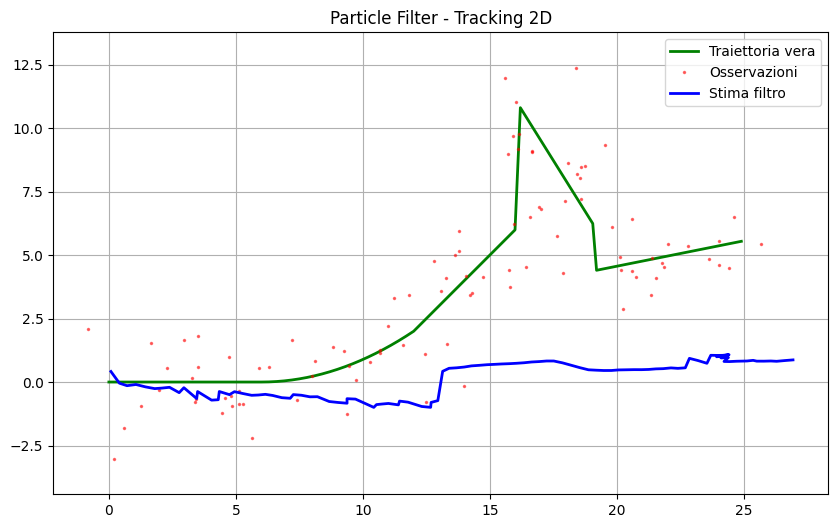

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('results_gpu_optimized.csv')
plt.figure(figsize=(10,6))
plt.plot(df['true_x'], df['true_y'], 'g-', label='Traiettoria vera', linewidth=2)
plt.plot(df['obs_x'], df['obs_y'], 'r.', label='Osservazioni', alpha=0.5, markersize=3)
plt.plot(df['est_x'], df['est_y'], 'b-', label='Stima filtro', linewidth=2)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.title('Particle Filter - Tracking 2D')
plt.savefig('tracking_result.png')
plt.show()

In [56]:
def load_data():
    """Load trajectory and particle data"""
    # Load trajectory data
    trajectory_df = pd.read_csv('results_gpu_optimized.csv')

    # Load particle data
    particles_df = pd.read_csv('particles.csv')

    return trajectory_df, particles_df

In [55]:
trajectory_df, particles_df = load_data()

fig, ax = plt.subplots(figsize=(12, 8))

    # Plot true trajectory
ax.plot(trajectory_df['true_x'], trajectory_df['true_y'],'r-', linewidth=3, label='True trajectory', alpha=0.8)

    # Plot estimated trajectory
ax.plot(trajectory_df['est_x'], trajectory_df['est_y'],'b--', linewidth=2, label='Estimated trajectory', alpha=0.8)

    # Plot observations
ax.scatter(trajectory_df['obs_x'], trajectory_df['obs_y'],c='green', s=30, alpha=0.6, label='Observations')

    # Plot particle clouds at selected timesteps
selected_timesteps = [0, 20, 40, 60, 80]
colors = ['purple', 'orange', 'cyan', 'magenta', 'yellow']

for i, timestep in enumerate(selected_timesteps):
    if timestep in particles_df['timestep'].values:
        particles_t = particles_df[particles_df['timestep'] == timestep]
        ax.scatter(particles_t['x'], particles_t['y'],c=colors[i], s=10, alpha=0.3,label=f'Particles t={timestep*0.1:.1f}s')

ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('Particle Filter Tracking - Complete Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('complete_trajectory.png', dpi=300, bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'particles.csv'